**Homework Day 16 - EDA with Python**

**Author: Ahmad Ichsan Baihaqi**

**Email: ahmadichsanbaihaqi@gmail.com**

### Dataset Background

Dataset: [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn)

Content: Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:
- Customers who left within the last month – the column is called Churn

- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

- Demographic info about customers – gender, age range, and if they have partners and dependents

### About the Project

In this project, I'll do EDA for Telco Customer Churn dataset.

**The objectives of this project are**:

1. Get insight about the churn correlation among other feature

2. Get information about features that highly affect (positively/negatively) the customer to churn

**Below is several things conducted to achieve the objectives**:

1. Data Profiling

2. Data Cleansing

3. Data Manipulation and/or Feature Engineering

4. Data Visualization

5. Exploratory Data Analysis (EDA)

**Target Feature**

1. Churn feature

## Installation

In [ ]:
# !pip install stringcase
# !pip install sweetviz
# !pip install -U pandas-profiling

## reference https://github.com/nekoumei/pyalluvial
# !pip install pyalluvial

## Import Lib

In [407]:
# import lib

import pandas as pd
import numpy as np
import re
import stringcase
from sklearn.preprocessing import LabelEncoder

from pandas_profiling import ProfileReport

import sweetviz as sv

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns
sns.set()

import pyalluvial.alluvial as alluvial

## Load Dataset

In [364]:
# Load dataset

df = pd.read_csv('telco-customer-churn.csv')

In [365]:
# Store in new variable the original value for later use

df_original = df[:]

## Analysis

In [366]:
# Get the dataframe's info 
# (number of rows, column name & type, number of missing rows per column, memory usage)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Insights:

1. There are 7043 rows of data with 21 columns.
2. Possible dropped column is `customerID`. This is because the value is unique and has high cardinality (we can find on the Pandas Profiling result later) and won't affect our analysis on target feature.
3. Column name inconsistency. Some of them lowercase (e.g. `gender`, `tenure`), some of them camelCase (e.g. `customerID`) and the rest is PascalCase. Since we will drop `customerID` column, we only need to rename the lowercase column name into PascalCase (follow the majority).
4. No column has null/missing values. But, don't fall to this information. Checkout the next information in the next point.
5. Data consist of 1 float feature, 2 integer features and 18 categorical features.<br />
   a. But, why type of `TotalCharges` is categorical instead of float like `MonthlyCharges`? This information related with information in point 4. Our above `df.info()` tell us there's no missing value. But, `TotalCharges` should be float instead of categorical. Let's see our 15 first data sort by smallest `TotalCharges`.<br />
   b. Since we still have categorical features, we need to do categorical data encoding. We are doing categorical data encoding because machine learning models require all input and output variables to be numeric, [[reference]](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/).

In [367]:
# sort by TotalCharges to get more insight why TotalCharges is categorical instead of float

df.sort_values(by=['TotalCharges']).head(15)[['tenure', 'TotalCharges']]

,tenure,TotalCharges
936,0,
3826,0,
4380,0,
753,0,
5218,0,
3331,0,
6754,0,
6670,0,
1340,0,
488,0,


Insights:

1. Based on above observation, there are rows contains string (whitespace). This not detected as missing value by pandas. But, this whitespace indeed a missing value.
2. All rows with empty `TotalCharges` is when the `tenure` is zero. `tenure` represents the number of months the customer has stayed with the company. It means, the `TotalCharges` is empty because the customer is not charged yet. So, to handle the empty value of `TotalCharges`, we can fill it with zero.

In [368]:
# Handling TotalCharges Missing Value

df.loc[df['TotalCharges'] == " ", 'TotalCharges'] = 0.00

In [369]:
# Casting type

df['TotalCharges'] = df['TotalCharges'].astype('float')

In [370]:
# Double check

df.sort_values(by=['TotalCharges']).head(15)[['tenure', 'TotalCharges']]

,tenure,TotalCharges
3826,0,0.00
5218,0,0.00
4380,0,0.00
753,0,0.00
488,0,0.00
1082,0,0.00
6754,0,0.00
936,0,0.00
1340,0,0.00
6670,0,0.00


In [371]:
# Drop customerID column

df.drop('customerID', axis = 1, inplace = True)

In [372]:
# Convert Column Name into PascalCase

df = df.rename(columns = lambda x: stringcase.pascalcase(x))

In [373]:
# Categorical Data Encoding

categorical_column = list(df.select_dtypes(include=['O']).columns)

# Encoding Function
def label_encoder(list_column, data_set):
    encoder = LabelEncoder()
    
    copied_data = data_set
    
    for item in list_column:
        copied_data[item] = encoder.fit_transform(copied_data[item])
        
    return copied_data

df = label_encoder(categorical_column, df)

In [374]:
# Double check after missing value in TotalCharges handled
# Double check after customerID dropped
# Double check after column name converted to PascalCase
# Double check after categorical feature encoded

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


Insights:

1. Now, the data consist of 2 float feature and 18 integer features.
2. No `customerID` feature anymore.
3. All column name now in PascalCase.

We are now ready to do EDA.

### Create Report with Pandas Profiling

First, create report to make an initial EDA

In [14]:
# create report with pandas profiling

pandas_profiling_report = df.profile_report(
    title = "Pandas Profiling Report",

    explorative = True,  # More analysis (Unicode)

    html = {
        'style':
          {
            'full_width': True,
            'theme': 'flatly'
          } # available theme options: ‘bootswatch’ ,'flatly','united'
    },
    
    # When a list of variable names is given, only interactions between these and all other variables are given.
    interactions = {'targets' : ['Churn']},

    progress_bar=True)

# pandas_profiling_report.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Create Report with Sweetviz

Use Sweetviz for another references in initial EDA

In [15]:
# create report with sweetviz

sweetviz_report = sv.analyze(
    source=df,
    target_feat="Churn"
)

# sweetviz_report.show_html("sweetviz_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Find Unique Value

By finding unique value, we could get identify, if a feature has unique value equal with the total data, it possible that those feature will not related with our target feature (e.g. `customerID` which we had drop before). On the other hand, if those feature only has 1 unique value, it means those feature also won't affect our target analysis. Then, we can drop the column.

In [375]:
def see_unique_value(data_set):
    unique_value = []
    col_name = list(data_set.columns)
    
    for item in col_name:
        unique_value.append(len(data_set[item].unique()))
    
    data = pd.DataFrame({
        'features': col_name,
        'total_unique': unique_value,
    })
    
    return data

see_unique_value(df)

,features,total_unique
0,Gender,2
1,SeniorCitizen,2
2,Partner,2
3,Dependents,2
4,Tenure,73
5,PhoneService,2
6,MultipleLines,3
7,InternetService,3
8,OnlineSecurity,3
9,OnlineBackup,3


Insights:

1. No features with 1 unique value nor has unique value equal with the total data. Thus, the rest of this feature might contribute to our target analysis.

### Visualize Target Feature

Before we dig down which feature can be used as predictor for our target feature, it's a good thing to visualize our target feature data distribution first.

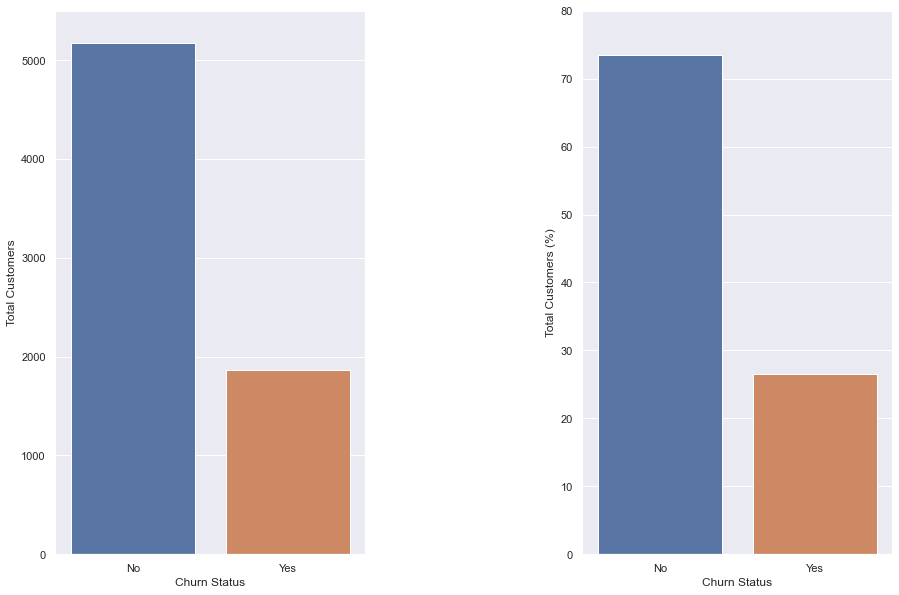

In [409]:
churn_percent = pd.DataFrame({
    'Churn Status': df_original['Churn'].unique(),
    'Total Customers': [item for item in df.groupby('Churn').size().transform(lambda x: (x/sum(x))*100)],
})

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

sns.countplot(
    data = df_original,
    x = "Churn",
    ax = axs[0]
).set(
    xlabel = "Churn Status",
    ylabel = "Total Customers",
    ylim = (0, 5500)
)

sns.barplot(
    data = churn_percent,
    x = "Churn Status",
    y = "Total Customers",
    ax=axs[1]
).set(
    xlabel = "Churn Status",
    ylabel = "Total Customers (%)",
    ylim = (0, 80)
)

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-status.png')

plt.show()

In [377]:
total_retained = len(df[df['Churn'] == 0])
print(f"Retained Customers: {total_retained}")

total_churn = len(df[df['Churn'] == 1])
print(f"Churn Customers: {total_churn}")

Retained Customers: 5174
Churn Customers: 1869


Insights:

1. There are 1869 customers who are churn and 5174 customers who are retained

### Feature Correlation Analysis

By using heatmap, we could identify which feature has high positive correlation and which feature has high negative correlation into our target feature. If a feature has a high positive correlation with our target feature, it means that increasing (or decreasing) in predictor value will also increase (or decrease) our target feature value. On the other hand, if a feature has a high negative correlation with our target feature, it means that increasing (or decreasing) in predictor value will decrease (or increase) our target feature value.

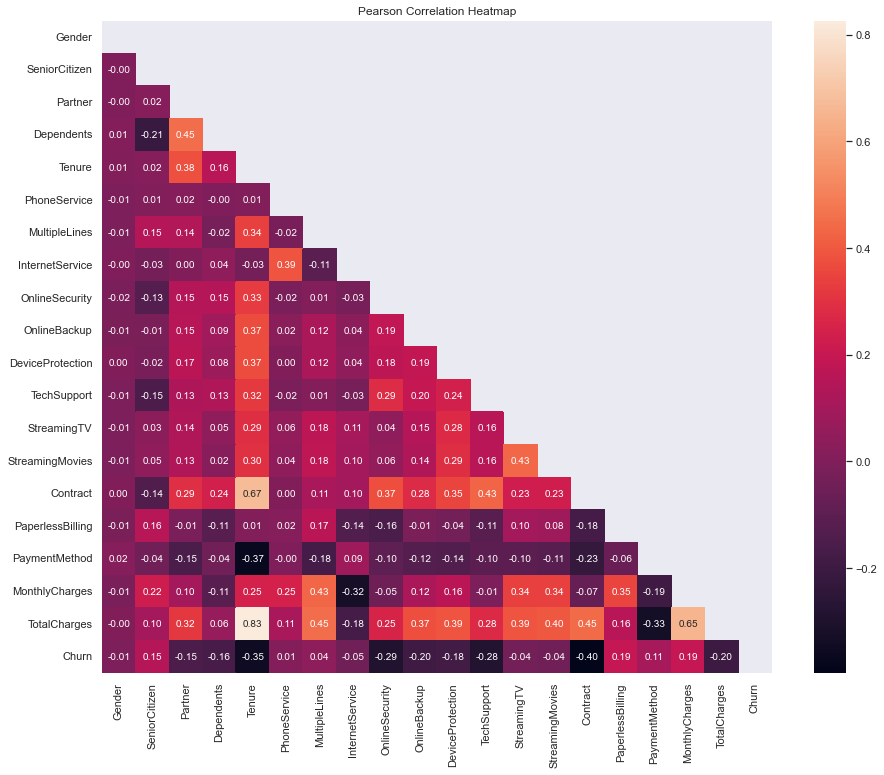

In [410]:
df_corr = df.corr()

mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 12))

ax = sns.heatmap(df_corr,
                 mask = mask, 
                 annot = True,
                 annot_kws={ 'size' : 10 },
                 fmt=".2f"
                )

plt.title("Pearson Correlation Heatmap")

# plt.savefig('heatmap.png')

plt.show()

Insights:

1. The highest positive correlation value is +0.19 (`PaperlessBilling` and `MonthlyCharges`). Followed by +0.15 (`SeniorCitizen`) and +0.11 (`PaymentMethod`).
2. The highest negative correlation value is -0.40 (`Contract`). Followed by -0.35 (`Tenure`) and -0.29 (`OnlineSecurity`).

### Churn Distribution by Paperless Billing

In [379]:
df_paperless_billing = df[:]

# only run once!
# df_paperless_billing['PaperlessBilling'] = df_paperless_billing['PaperlessBilling'].apply(lambda x: "No" if x == 0 else "Yes")


In [380]:
df_paperless_billing.groupby(['PaperlessBilling'])[['Churn']].agg({'count','mean'})

Churn          
                 count      mean
PaperlessBilling                
No                2872  0.163301
Yes               4171  0.335651

In [381]:
multiplication = 0.335651 / 0.163301

multiplication

2.0554130103306165

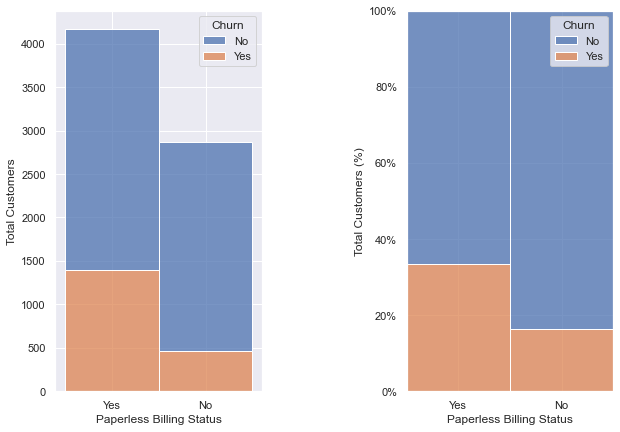

In [411]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sns.histplot(
    df_original,
    x = "PaperlessBilling",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Paperless Billing Status",
    ylabel = "Total Customers",
)

sns.histplot(
    df_original,
    x = "PaperlessBilling",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Paperless Billing Status",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-paperless-billing.png')

plt.show()

Insigths:

1. Customers with paperless billing are (approx) 2 times more frequently to left Telco (churn), than clients with paper billing. This indicator is significant and should be taken into account as a predictor feature.

### Churn Distribution by Senior Citizen

In [383]:
df_senior_citizen = df[:]

# only run once!
# df_senior_citizen['SeniorCitizen'] = df_senior_citizen['SeniorCitizen'].apply(lambda x: "No" if x == 0 else "Yes")


In [384]:
df_senior_citizen.groupby(['SeniorCitizen'])[['Churn']].agg({'count','mean'})

Churn          
              count      mean
SeniorCitizen                
No             5901  0.236062
Yes            1142  0.416813

In [385]:
multiplication_sc = 0.416813 / 0.236062

multiplication_sc

1.7656929111843498

In [386]:
df_senior_citizen_churn = df_senior_citizen[:]

# only run once!
# df_senior_citizen_churn['Churn'] = df_senior_citizen_churn['Churn'].apply(lambda x: "No" if x == 0 else "Yes")


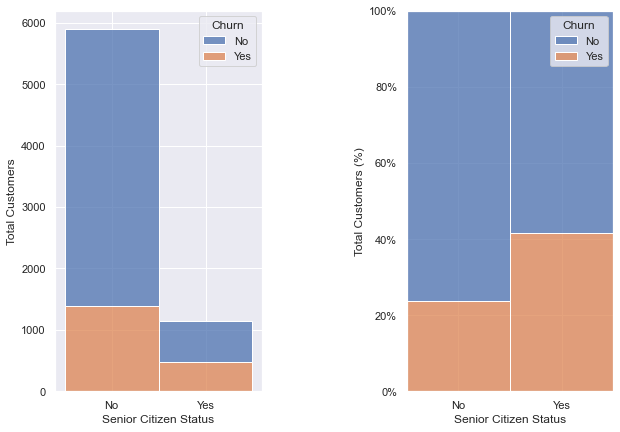

In [427]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sns.histplot(
    df_senior_citizen_churn,
    x = "SeniorCitizen",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Senior Citizen Status",
    ylabel = "Total Customers",
)
    
sns.histplot(
    df_senior_citizen_churn,
    x = "SeniorCitizen",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Senior Citizen Status",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-senior-citizen.png')

Insigths:

1. Telco customer is dominant by non-senior citizens.
2. Based on the ratio, senior citizens tend to left Telco 1.7 times more than non-senior citizens. This feature can be considered as a good predictor for our target feature.

### Churn Distribution by Payment Method

In [388]:
df_payment_method = df_original[:]

# only run once!
# df_payment_method['Churn'] = df_payment_method['Churn'].apply(lambda x: 0 if x == "No" else 1)


In [389]:
df_payment_method.groupby(['PaymentMethod'])[['Churn']].agg({'count','mean'})

Churn          
                          count      mean
PaymentMethod                            
Bank transfer (automatic)  1544  0.167098
Credit card (automatic)    1522  0.152431
Electronic check           2365  0.452854
Mailed check               1612  0.191067

In [390]:
# Bank transfer (automatic)	1544	0.167098
# Credit card (automatic)	1522	0.152431
# Electronic check	2365	0.452854
# Mailed check	1612	0.191067

ec_over_bt = 0.452854 / 0.167098
ec_over_cc = 0.452854 / 0.152431
ec_over_mc = 0.452854 / 0.191067
print(ec_over_bt)
print(ec_over_cc)
print(ec_over_mc)

ec_mean = np.mean([ec_over_bt, ec_over_cc, ec_over_mc])
print(ec_mean)

2.710110234712564
2.9708786270509275
2.3701319432450396
2.683706935002844


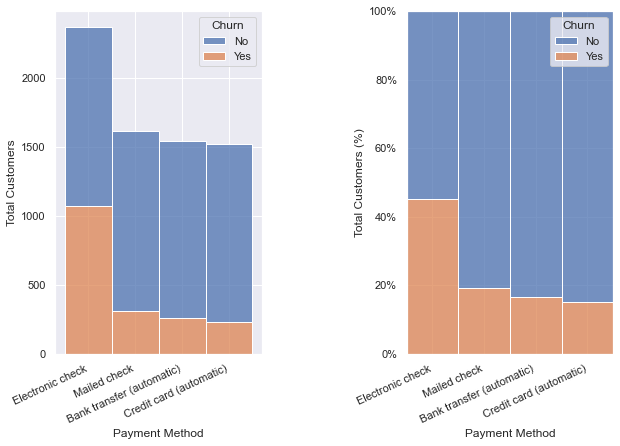

In [428]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 2, figsize=(10, 7))

fig.autofmt_xdate(rotation = 25)

sns.histplot(
    df_original,
    x = "PaymentMethod",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Payment Method",
    ylabel = "Total Customers",
)

sns.histplot(
    df_original,
    x = "PaymentMethod",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Payment Method",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-payment-method.png')

Insigths:

1. There are 4 payment method available for Telco customer:<br />
   a. Electronic check<br />
   b. Mailed check<br />
   c. Bank transfer (automatic)<br />
   d. Credit card (automatic)
2. Most of the customer use Electronic check.
3. Customer which using Electronic check tend to left Telco 2.6 times than the other payment method.
4. This feature is a good candidate for our target feature predictor.

### Alluvial Diagram between Payment Method, Senior Citizen and Churn

In [392]:
df_alluvial = df_original[:]

## only run once!
# df_alluvial['SeniorCitizen'] = df_alluvial['SeniorCitizen'].apply(lambda x: "No" if x == 0 else "Yes")


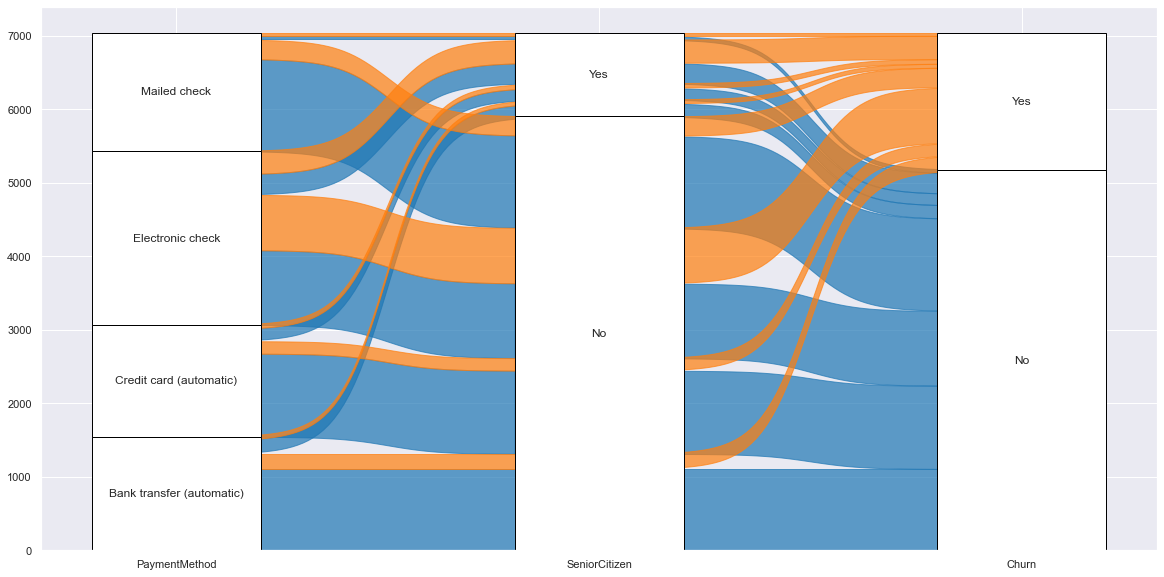

In [420]:
# create wide format dataframe
df_alluvial['freq'] = 1

wide_df = df_alluvial[['PaymentMethod', 'SeniorCitizen', 'Churn', 'freq']].groupby(['PaymentMethod', 'SeniorCitizen', 'Churn'], as_index=False).sum()

# draw alluvial plot
fig = alluvial.plot(
    df = wide_df,
    xaxis_names = ['PaymentMethod', 'SeniorCitizen', 'Churn'],
    y_name = 'freq',
    alluvium = 'Churn',
    figsize = (20,10)
)

# fig.savefig('alluvial.png')


In [394]:
print(df['PaymentMethod'].unique())
print(df_original['PaymentMethod'].unique())

[2 3 0 1]
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [395]:
from itertools import product

df_pm_unique = sorted(df['PaymentMethod'].unique())
df_sc_unique = sorted(df['SeniorCitizen'].unique())

df_alluvial_pm_unique = sorted(df_alluvial['PaymentMethod'].unique())
df_alluvial_sc_unique = sorted(df_alluvial['SeniorCitizen'].unique())

permutation_list = list(product(
    df_pm_unique,
    df_sc_unique,
))

permutation_list_alluvial = list(product(
    df_alluvial_pm_unique,
    df_alluvial_sc_unique,
))

total_data = len(df.index)
total_churn_data = len(df[df['Churn'] == 1].index)

avgs_churn = []
avgs = []

for index, item in enumerate(permutation_list):
    sum_total = len(df[(df['PaymentMethod'] == item[0]) & (df['SeniorCitizen'] == item[1]) & (df['Churn'] == 1)].index)
    avg_churn = sum_total / total_churn_data
    avg = sum_total / total_data
    
    avgs_churn.append(avg_churn)
    avgs.append(avg)

df_ratio = pd.DataFrame({
    'Payment Method': [item[0] for item in permutation_list_alluvial],
    'Senior Citizen': ["Senior Citizen" if item[1] == "Yes" else "Non-Senior" for item in permutation_list_alluvial],
    'Occurence from Total Population (%)': [item * 100 for item in avgs],
    'Occurence from Total Churn (%)': [item * 100 for item in avgs_churn],
})

df_ratio
    

,Payment Method,Senior Citizen,Occurence from Total Population (%),Occurence from Total Churn (%)
0,Bank transfer (automatic),Non-Senior,2.910691,10.968432
1,Bank transfer (automatic),Senior Citizen,0.752520,2.835741
2,Credit card (automatic),Non-Senior,2.413744,9.095773
3,Credit card (automatic),Senior Citizen,0.880307,3.317282
4,Electronic check,Non-Senior,10.705665,40.342429
5,Electronic check,Senior Citizen,4.500923,16.960942
6,Mailed check,Non-Senior,3.748403,14.125201
7,Mailed check,Senior Citizen,0.624734,2.354200


Insight:

1. On churn distribution by senior citizen, senior citizen customers tend to churn more than non-senior citizen customers. Then, on churn distribution by payment method, customers using electronic check tend to churn more than those who use the other method. But, based on above alluvial diagram, I tried to visualize distribution of combination between `SeniorCitizen`, `PaymentMethod` and `Churn` to find out if different `SeniorCitizen` will have segmentation in `PaymentMethod` they are using. The result is the combination with highest churn ratio is `PaymentMethod` with Electronic Check in Non-Senior Citizen customers with 40.3% occurence from total churn and 10.7% occurence from total population. This might be happened because in terms of ease of use, Electronic check is not favorable for non-senior citizen since it will take much more time to do payment with check rather than credit card or bank transfer.

### Churn Distribution by MonthlyCharges

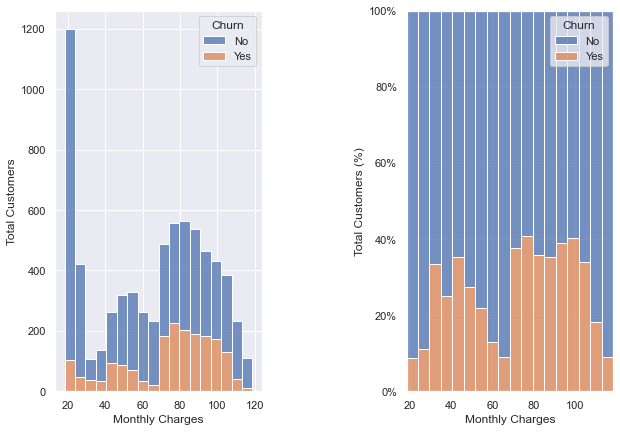

In [426]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sns.histplot(
    df_original,
    x = "MonthlyCharges",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Monthly Charges",
    ylabel = "Total Customers",
)
    
sns.histplot(
    df_original,
    x = "MonthlyCharges",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Monthly Charges",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-monthly-charges.png')

Insights:

1. Distribution of churn customer based on `MonthlyCharges` is quite interesting. Customer who paid 20 - 30 USD, 60 - 70 USD and above 110 USD have low churn customer. Otherwise, the churn rate is high. This distribution possibly affected by other feature, such as `Contract`. Different type of `Contract` might have different monthly charges.

### Churn Distribution by Contract

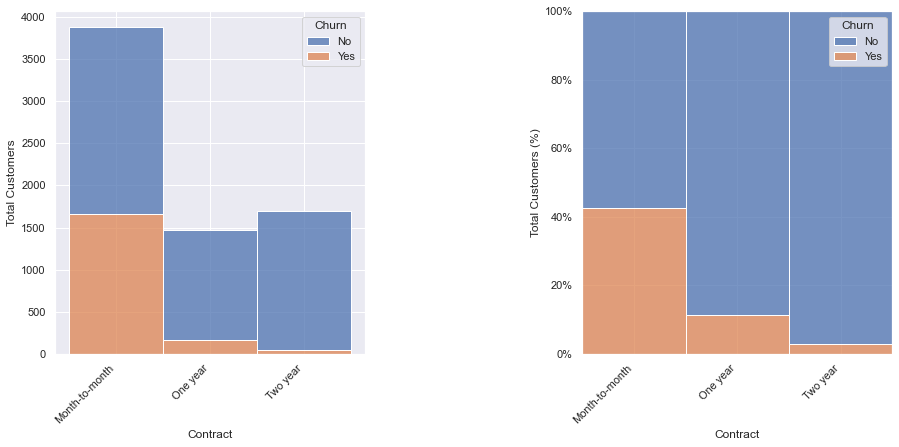

In [430]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.autofmt_xdate(rotation = 45)

sns.histplot(
    df_original,
    x = "Contract",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Contract",
    ylabel = "Total Customers",
)

sns.histplot(
    df_original,
    x = "Contract",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Contract",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('contract-churn.png')

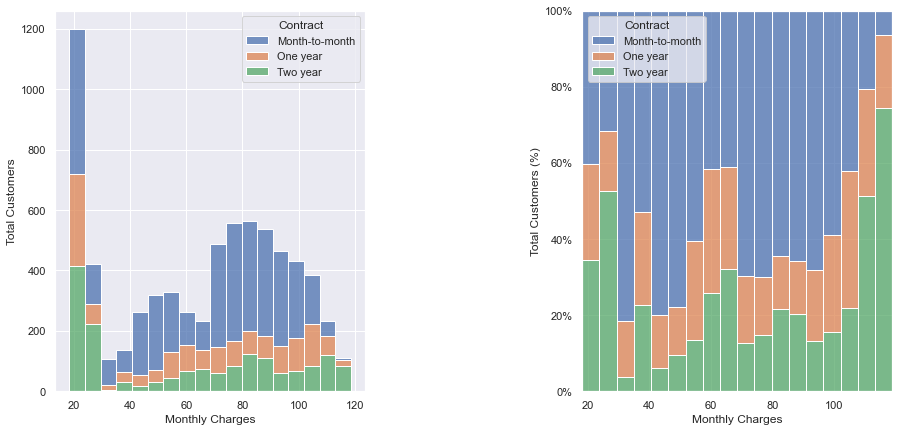

In [429]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(
    df_original,
    x = "MonthlyCharges",
    hue = "Contract",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Monthly Charges",
    ylabel = "Total Customers",
)
    
sns.histplot(
    df_original,
    x = "MonthlyCharges",
    hue = "Contract",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Monthly Charges",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('contract-monthly-charge.png')

Insights:

1. It's quite interesting that our previous claim is not proven based on above diagram. Above diagram tell us that Month-to-Month contract mostly has low monthly charges. It means, the high churn rate for higher monthly charges is not because the contract is Month-to-Month.
2. Still, the Month-to-Month contract type has high churn rate, thus it's a good candidate as predictor. The high negative correlation means from Month-to-Month (0 index), One year (1 index) until Two year (2 index), the churn rate is decreased.

In [399]:
print(df['Contract'].unique())
print(df_original['Contract'].unique())

[0 1 2]
['Month-to-month' 'One year' 'Two year']


In [400]:
df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [401]:
mtm_monthly_charges = df[df['Contract'] == 0]['MonthlyCharges']
mtm_monthly_charges.describe()

count    3875.000000
mean       66.398490
std        26.926599
min        18.750000
25%        45.850000
50%        73.250000
75%        88.875000
max       117.450000
Name: MonthlyCharges, dtype: float64

In [402]:
oy_monthly_charges = df[df['Contract'] == 1]['MonthlyCharges']
oy_monthly_charges.describe()

count    1473.000000
mean       65.048608
std        31.840539
min        18.250000
25%        26.900000
50%        68.750000
75%        94.800000
max       118.600000
Name: MonthlyCharges, dtype: float64

In [403]:
ty_monthly_charges = df[df['Contract'] == 2]['MonthlyCharges']
ty_monthly_charges.describe()

count    1695.000000
mean       60.770413
std        34.678865
min        18.400000
25%        24.025000
50%        64.350000
75%        90.450000
max       118.750000
Name: MonthlyCharges, dtype: float64

### Churn Distribution by Tenure

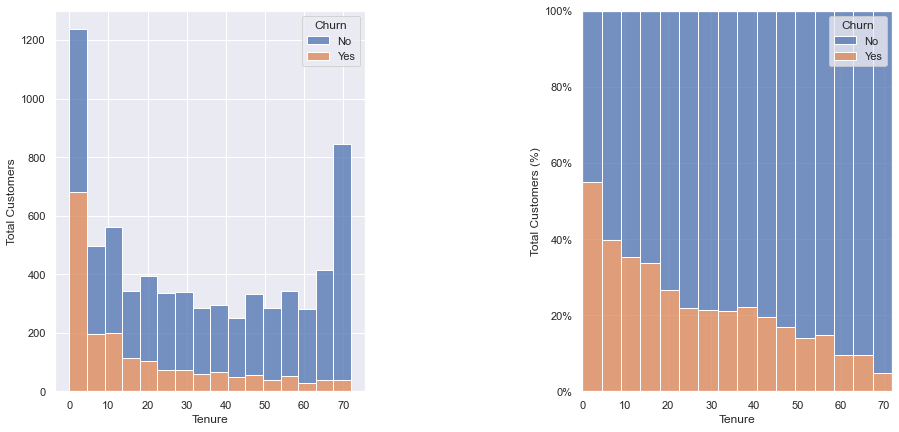

In [431]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(
    df_original,
    x = "tenure",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Tenure",
    ylabel = "Total Customers",
)
    
sns.histplot(
    df_original,
    x = "tenure",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1]
).set(
    xlabel = "Tenure",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-tenure.png')

Insights:

1. Tenure and churn has high negative correlation between them. It means, the longer the customer stay (high tenure value) the churn rate is decreasing.
2. Thus, tenure is a good candidate as predictor.

### Churn Distribution by OnlineSecurity

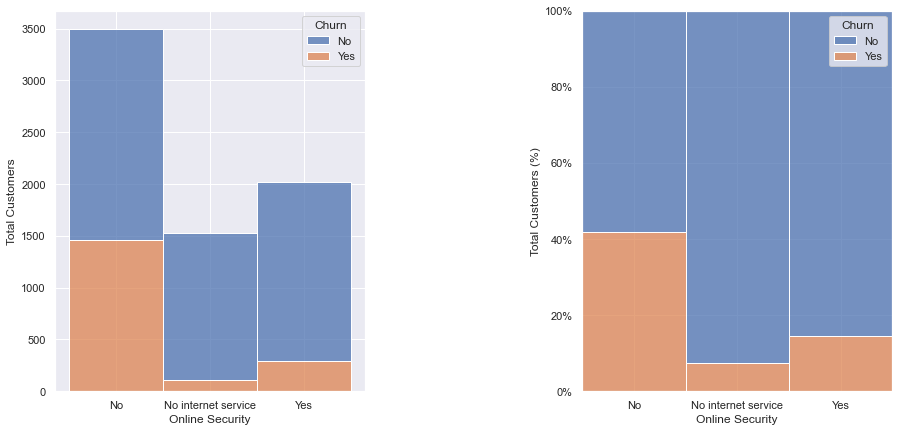

In [432]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sorted_online_security = df_original[:]
sorted_online_security = sorted_online_security.sort_values('OnlineSecurity')

sns.histplot(
    sorted_online_security,
    x = "OnlineSecurity",
    hue = "Churn",
    multiple = "stack",
    ax = axs[0]
).set(
    xlabel = "Online Security",
    ylabel = "Total Customers",
)
    
sns.histplot(
    sorted_online_security,
    x = "OnlineSecurity",
    hue = "Churn",
    multiple = "fill",
    ax = axs[1],
).set(
    xlabel = "Online Security",
    ylabel = "Total Customers (%)",
)

axs[1].yaxis.set_major_formatter(PercentFormatter(1))

plt.subplots_adjust(wspace = 0.7)

# plt.savefig('churn-online-security.png')

Insights:

1. The correlation between `OnlineSecurity` and `Churn` is a negative correlation. But, it's not the highest. See above histogram, the rate is not always decreasing. But, the churn rate trend is decreasing.
2. The high negative correlation in `OnlineSecurity` is a good candidate as predictor feature.

In [406]:
print(df['OnlineSecurity'].unique())
print(df_original['OnlineSecurity'].unique())

[0 2 1]
['No' 'Yes' 'No internet service']


## Conclusion

1. The highest positive correlation value is +0.19 (`PaperlessBilling` and `MonthlyCharges`). Followed by +0.15 (`SeniorCitizen`) and +0.11 (PaymentMethod).
2. The highest negative correlation value is -0.40 (`Contract`). Followed by -0.35 (`Tenure`) and -0.29 (`OnlineSecurity`).